In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/src/master/

Cloning into 'master'...
Unpacking objects: 100% (6/6), 117.80 MiB | 5.48 MiB/s, done.
Updating files: 100% (4/4), done.


In [ ]:
!cd master

In [ ]:
!mv master german-traffic-signs

In [ ]:
!ls

german-traffic-signs  sample_data


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

In [ ]:
print(type(train_data))

<class 'dict'>


In [ ]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The numbers of training images does not match the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The numbers of validation images does not match the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The numbers of test images does not match the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The training dimensions are wrong"
assert(X_val.shape[1:] == (32, 32, 3)), "The validation dimensions are wrong"
assert(X_test.shape[1:] == (32, 32, 3)), "The test dimensions are wrong"

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

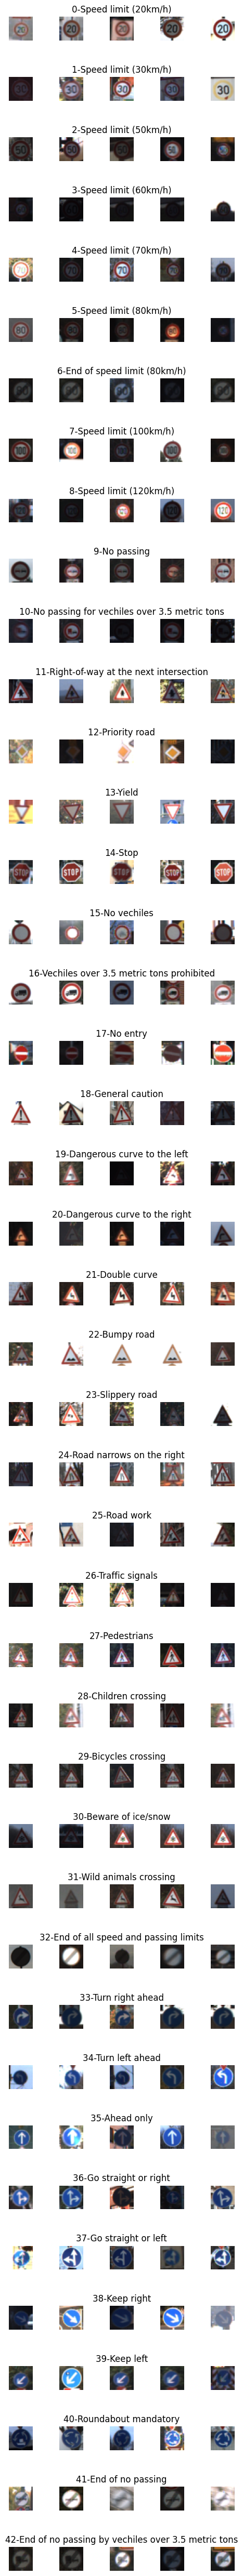

In [ ]:
num_of_samples = []
cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      num_of_samples.append(len(x_selected))
      axs[j][i].set_title(str(j)+"-"+row["SignName"])

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

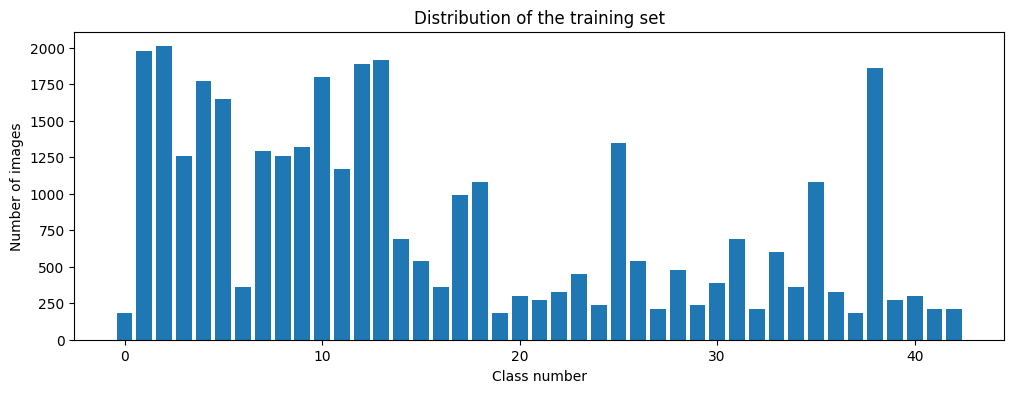

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training set")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


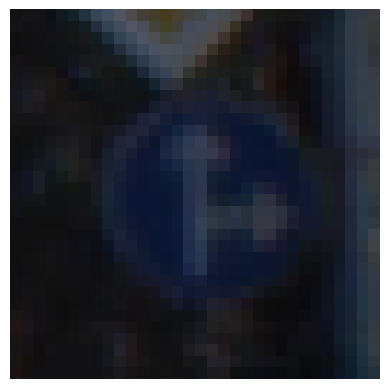

In [ ]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

(-0.5, 31.5, 31.5, -0.5)

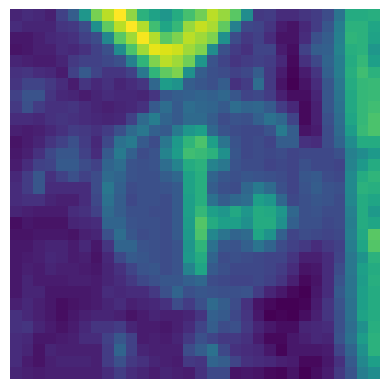

In [ ]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img


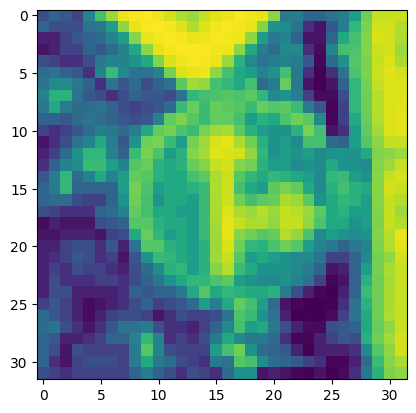

In [ ]:
img = equalize(img)
plt.imshow(img)

In [ ]:
def preprocess(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

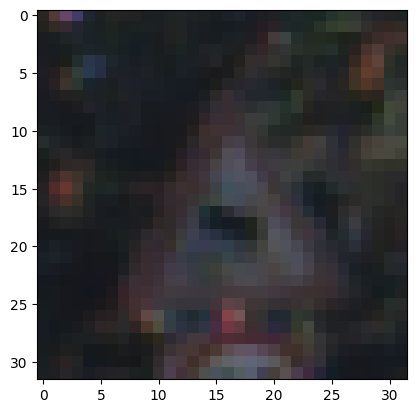

In [ ]:
plt.imshow(X_train[random.randint(0, (len(X_train)-1))])

In [ ]:
X_train = np.array(list(map(preprocess, X_train)))
X_val = np.array(list(map(preprocess, X_val)))
X_test = np.array(list(map(preprocess, X_test)))
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)


In [ ]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [ ]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(15, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = leNet_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 30)        780       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 30)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 15)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 540)               0         
                                                                 
 dense (Dense)               (None, 500)               2

Epoch 1/10
87/87 [==============================] - 12s 17ms/step - loss: 3.0800 - accuracy: 0.1788 - val_loss: 1.8849 - val_accuracy: 0.4408
Epoch 2/10
87/87 [==============================] - 1s 10ms/step - loss: 1.4878 - accuracy: 0.5439 - val_loss: 1.2262 - val_accuracy: 0.6390
Epoch 3/10
87/87 [==============================] - 1s 8ms/step - loss: 1.1210 - accuracy: 0.6471 - val_loss: 0.9483 - val_accuracy: 0.7304
Epoch 4/10
87/87 [==============================] - 1s 8ms/step - loss: 0.9204 - accuracy: 0.7054 - val_loss: 0.7826 - val_accuracy: 0.7819
Epoch 5/10
87/87 [==============================] - 1s 8ms/step - loss: 0.7453 - accuracy: 0.7618 - val_loss: 0.7006 - val_accuracy: 0.8091
Epoch 6/10
87/87 [==============================] - 1s 8ms/step - loss: 0.6258 - accuracy: 0.8001 - val_loss: 0.5568 - val_accuracy: 0.8533
Epoch 7/10
87/87 [==============================] - 1s 8ms/step - loss: 0.5537 - accuracy: 0.8218 - val_loss: 0.5653 - val_accuracy: 0.8535
Epoch 8/10
87/87 

Text(0.5, 0, 'Epoch')

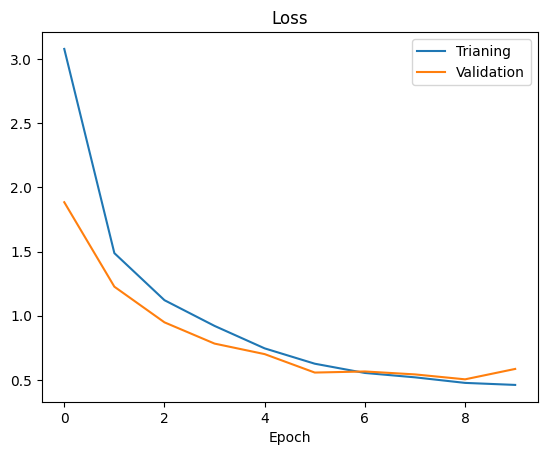

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Trianing", "Validation"])
plt.title("Loss")
plt.xlabel("Epoch")